### MMDetection 설치

In [ ]:
!pip install mmcv-full
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [ ]:
# 런타임->런타임 다시 시작 후 아래 수행. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### Oxford Pet Dataset 다운로드 
image와 annotations을 압축파일로 각각 download 수행. 

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

### 이미지 디렉토리와 annotation 파일 살펴 보기

In [ ]:
!ls -lia ./data/images/Abyss*.jpg

In [ ]:
!ls -lia ./data/images

In [ ]:
!cat ./data/annotations/xmls/Abyssinian_1.xml

In [ ]:
import glob
import xml.etree.ElementTree as ET

# annotation xml 파일 파싱해서 bbox정보 추출
def get_bboxes_from_xml_test(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  bbox_names = []
  bboxes = []
  # 파일내에 있는 모든 object Element를 찾음. 
  for obj in root.findall('object'):

    bbox_name = obj.find('name').text
    xmlbox = obj.find('bndbox')
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)

    bbox_names.append(bbox_name)
    bboxes.append([x1, y1, x2, y2])

  return bbox_names, bboxes

get_bboxes_from_xml_test('./data/annotations/xmls/Abyssinian_1.xml')

In [ ]:
!ls -lia ./data/annotations/xmls/Abys*.xml

### train, val image/annotation 메타 파일 보기
* train과 valid 데이터로 나뉠 image와 annotation의 파일명을 가지는 메타 파일
* train과 valid용 meta 파일을 별도로 만듬. 

In [ ]:
!cd ./data/annotations; cat trainval.txt

In [ ]:
import pandas as pd

pet_df = pd.read_csv('./data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
pet_df.head()

In [ ]:
pet_df['class_id'].value_counts()

In [ ]:
pet_df['class_name'] = pet_df['img_name'].apply(lambda x:x[:x.rfind('_')])
pet_df.head()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(pet_df, test_size=0.1, stratify=pet_df['class_id'], random_state=2021)

In [ ]:
print(train_df['class_id'].value_counts(), val_df['class_id'].value_counts())

In [ ]:
train_df = train_df.sort_values(by='img_name')
val_df = val_df.sort_values(by='img_name')

In [ ]:
# ann_file로 주어지는 메타파일은 가급적이면 소스데이터의 가장 상단 디렉토리에 저장하는 것이 바람직. 
train_df['img_name'].to_csv('./data/train.txt', sep=' ', header=False, index=False)
val_df['img_name'].to_csv('./data/val.txt', sep=' ', header=False, index=False)

In [ ]:
pet_classes_list = pet_df['class_name'].unique().tolist()
print(pet_classes_list)

In [ ]:
!echo 'train list #####'; cat ./data/train.txt

In [ ]:
!echo ' valid list ###'; cat ./data/val.txt

### mmdetection의 중립 annotation 포맷 변환
* CLASSES 는 pet_df의 'class_name' 컬럼에 unique 데이터로 지정. class id는 tuple(list)형의 CLASSES의 index값에 따라 설정. 
* ann_file로 입력되는 메타 파일을 읽어서 개별 image정보와 ann 정보를 dict로 생성하여 data_infos list에 입력
* 개별 XML 읽어서 ann 정보를 만드는 것은 get_bboxes_from_xml() 함수 이용. 
* 디버깅용으로 CustomDataset을 만들어서 미리 테스트 하는 방법도 고려. 

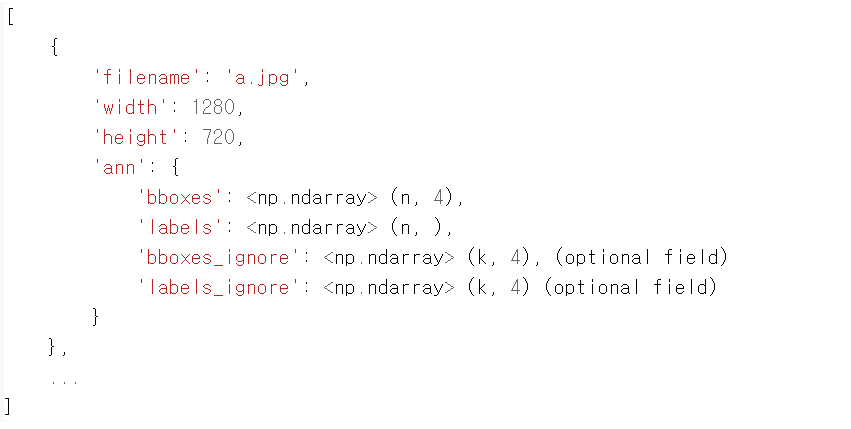

In [ ]:
import xml.etree.ElementTree as ET

# 1개의 annotation 파일에서 bbox 정보 추출. 여러개의 object가 있을 경우 이들 object의 name과 bbox 좌표들을 list로 반환.
def get_bboxes_from_xml(anno_dir, xml_file):
  anno_xml_file = osp.join(anno_dir, xml_file)
  tree = ET.parse(anno_xml_file)
  root = tree.getroot()
  bbox_names = []
  bboxes = []

  # 파일내에 있는 모든 object Element를 찾음. 
  for obj in root.findall('object'):
    #obj.find('name').text는 cat 이나 dog을 반환     
    #bbox_name = obj.find('name').text
    # object의 클래스명은 파일명에서 추출. 
    bbox_name = xml_file[:xml_file.rfind('_')]

    xmlbox = obj.find('bndbox')
    x1 = int(xmlbox.find('xmin').text)
    y1 = int(xmlbox.find('ymin').text)
    x2 = int(xmlbox.find('xmax').text)
    y2 = int(xmlbox.find('ymax').text)

    bboxes.append([x1, y1, x2, y2])
    bbox_names.append(bbox_name)

  return bbox_names, bboxes

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np
import cv2

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

import xml.etree.ElementTree as ET

PET_CLASSES = pet_df['class_name'].unique().tolist()

@DATASETS.register_module(force=True)
class PetDataset(CustomDataset):
  CLASSES = PET_CLASSES

  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 
  # 이 self.ann_file이 load_annotations()의 인자로 입력
  def load_annotations(self, ann_file):
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = []

    for image_id in image_list:
      # self.img_prefix는 images 가 입력될 것임. 
      filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함. 
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': filename,
                  'width': width, 'height': height}
      # 개별 annotation XML 파일이 있는 서브 디렉토리의 prefix 변환. 
      label_prefix = self.img_prefix.replace('images', 'annotations')
      
      # 개별 annotation XML 파일을 1개 line 씩 읽어서 list 로드. annotation XML파일이 xmls 밑에 있음에 유의
      anno_xml_file = osp.join(label_prefix, 'xmls/'+str(image_id)+'.xml')
      # 메타 파일에는 이름이 있으나 실제로는 존재하지 않는 XML이 있으므로 이는 제외. 
      if not osp.exists(anno_xml_file):
          continue
      
      # get_bboxes_from_xml() 를 이용하여 개별 XML 파일에 있는 이미지의 모든 bbox 정보를 list 객체로 생성. 
      anno_dir = osp.join(label_prefix, 'xmls')
      bbox_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id)+'.xml')
      #print('#########:', bbox_names)
                  
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []
        
      # bbox별 Object들의 class name을 class id로 매핑. class id는 tuple(list)형의 CLASSES의 index값에 따라 설정
      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        # bbox_name이 CLASSES중에 반드시 하나 있어야 함. 안 그러면 FILTERING 되므로 주의 할것. 
        if bbox_name in cat2label:
            gt_bboxes.append(bbox)
            # gt_labels에는 class id를 입력
            gt_labels.append(cat2label[bbox_name])
        else:
            gt_bboxes_ignore.append(bbox)
            gt_labels_ignore.append(-1)
      
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값을 np.array형태로 bbox의 좌표와 label값으로 생성. 
      data_anno = {
        'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
        'labels': np.array(gt_labels, dtype=np.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)
      #print(data_info)

    return data_infos


In [ ]:
''' 디버깅 용도로 CustomDataset을 흉내낸 클래스를 생성하여 다양한 테스트를 수행 가능 '''

import os.path as osp

PET_CLASSES = pet_df['class_name'].unique().tolist()

# 디버깅 용도로 CustomDataset을 흉내낸 클래스 생성. 
class PetDataset_imsi():
  CLASSES = PET_CLASSES

  # 생성자 함수 생성. 
  def __init__(self, data_root, ann_file, img_prefix):
      self.data_root = data_root
      self.ann_file = osp.join(data_root, ann_file)
      self.img_prefix = osp.join(data_root, img_prefix)
      
      self.data_infos = self.load_annotations(self.ann_file)

  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 
  # 이 self.ann_file이 load_annotations()의 인자로 입력
  def load_annotations(self, ann_file):
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = []

    for image_id in image_list:
      # self.img_prefix는 images 가 입력될 것임. 
      filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함. 
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': filename,
                  'width': width, 'height': height}
      # 개별 annotation XML 파일이 있는 서브 디렉토리의 prefix 변환. 
      label_prefix = self.img_prefix.replace('images', 'annotations')
      
      # 개별 annotation XML 파일을 1개 line 씩 읽어서 list 로드. annotation XML파일이 xmls 밑에 있음에 유의
      anno_xml_file = osp.join(label_prefix, 'xmls/'+str(image_id)+'.xml')
      # 메타 파일에는 이름이 있으나 실제로는 존재하지 않는 XML이 있으므로 이는 제외. 
      if not osp.exists(anno_xml_file):
          continue
      
      # get_bboxes_from_xml() 를 이용하여 개별 XML 파일에 있는 이미지의 모든 bbox 정보를 list 객체로 생성. 
      anno_dir = osp.join(label_prefix, 'xmls')
      bbox_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id)+'.xml')
      #print('#########:', bbox_names)
                  
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []
        
      # bbox별 Object들의 class name을 class id로 매핑. class id는 tuple(list)형의 CLASSES의 index값에 따라 설정
      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        # bbox_name이 CLASSES중에 반드시 하나 있어야 함. 안 그러면 FILTERING 되므로 주의 할것. 
        if bbox_name in cat2label:
            gt_bboxes.append(bbox)
            # gt_labels에는 class id를 입력
            gt_labels.append(cat2label[bbox_name])
        else:
            gt_bboxes_ignore.append(bbox)
            gt_labels_ignore.append(-1)
      
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값을 np.array형태로 bbox의 좌표와 label값으로 생성. 
      data_anno = {
        'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
        'labels': np.array(gt_labels, dtype=np.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)
      #print(data_info)

    return data_infos


In [ ]:
# 디버깅 용도로 생성한 클래스를 생성하고 data_infos를 10개만 추출하여 생성된 데이터 확인. 
train_ds = PetDataset_imsi(data_root='/content/data', ann_file='train.txt', img_prefix='images')
print(train_ds.data_infos[:10])

### Config를 설정하고 COCO로 Pretrained 된 모델을 Download
* config파일은 faster rcnn resnet 50 backbone 사용. 
* Oxford Pet 데이터는 학습에 시간에 소모 되므로 학습으로 생성된 모델을 Google Drive에 저장

In [ ]:
config_file = './mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = './mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [ ]:
!cd mmdetection; mkdir checkpoints
!wget -O ./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

In [ ]:
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생. 
!mkdir "/mydrive/pet_work_dir"

In [ ]:
!nvidia-smi

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'PetDataset'
cfg.data_root = '/content/data/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'PetDataset'
cfg.data.train.data_root = '/content/data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PetDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 37
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리로 구글 Drive 설정. 
cfg.work_dir = '/mydrive/pet_work_dir'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 5

cfg.runner.max_epochs = 5

# 평가 metric 설정. 
cfg.evaluation.metric = 'mAP'
# 평가 metric 수행할 epoch interval 설정. 
cfg.evaluation.interval = 5
# 학습 iteration시마다 모델을 저장할 epoch interval 설정. 
cfg.checkpoint_config.interval = 5

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨)
cfg.data.samples_per_gpu = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

### Train용 데이터를 생성하고 Oxford Dataset을 학습수행. 
* build_dataset()로 train config 설정에 따른 Train용 dataset 생성. 
* build_detector()로 train과 test config반영하여 model 생성. 
* train_detector()로 model 학습.  

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

In [ ]:
datasets

In [ ]:
%cd mmdetection

model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets, cfg, distributed=False, validate=True)

### 학습된 model을 이용하여 inference 수행.
* 현재 memory에서 학습된 model 및 checkpoint 기록된 model을 loading하여 inference 수행.  

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [ ]:
result

In [ ]:
# 아래는 오류를 발생시킵니다. 현재 Customized학습된 모델의 inference시 image file로 인자가 주어졌을때 inference 오류 발생. 
img_path = '/content/data/images/Abyssinian_88.jpg'

model.cfg = cfg

result = inference_detector(model, img_path)
show_result_pyplot(model, img, result, score_thr=0.3)

### Checkpoint 저장된 model 파일을 로딩하고 이를 이용하여 Inference 수행. 

In [ ]:
from mmdet.apis import show_result_pyplot

checkpoint_file = '/mydrive/pet_work_dir/epoch_5.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')
# BGR Image 사용 
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')
#model_ckpt.cfg = cfg

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.3)

### 여러개의 image들을 Inference 수행. 
* inference_detector(model, imgs) 에서 인자 imgs는 단일 이미지일 경우 string/array, 여러개의 이미지일 경우 list(string/array)를 입력
* show_result_pyplot(model_ckpt, img, result, score_thr=0.3)는 여러개의 이미지를 한번에 나타내기 어려우므로 별도의 시각화 함수 get_detected_img()를 이용

In [ ]:
val_df

In [ ]:
val_df['img_path'] = '/content/data/images/' + val_df['img_name'] + '.jpg'
val_df.head()

In [ ]:
val_df[val_df['img_path'].str.contains('Abyssinian')]['img_path'].values

In [ ]:
val_paths = val_df[val_df['img_path'].str.contains('Abyssinian')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

In [ ]:
type(val_imgs), len(val_imgs), val_imgs[0].shape

In [ ]:
# 반환된 results는 개별 원소로 list를 가지는 list임. 
results = inference_detector(model_ckpt, val_imgs)

In [ ]:
len(results), len(results[0]), results

In [ ]:
PET_CLASSES = pet_df['class_name'].unique().tolist()
labels_to_names_seq = {i:k for i, k in enumerate(PET_CLASSES)}

# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성. 
def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, result in enumerate(results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(result) == 0:
      continue
    
    # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외. 
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출. 
      left = int(result_filtered[i, 0])
      top = int(result_filtered[i, 1])
      right = int(result_filtered[i, 2])
      bottom = int(result_filtered[i, 3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1)
      if is_print:
        print(caption)

  return draw_img

In [ ]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/data/images/Abyssinian_88.jpg')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.3, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환 
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

def show_detected_images(model, img_arrays, ncols=5):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
      detected_img = get_detected_img(model, img_arrays[i],  score_threshold=0.5, is_print=True)
      detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
      #detected_img = cv2.resize(detected_img, (328, 328))
      axs[i].imshow(detected_img)

        
show_detected_images(model_ckpt, val_imgs[:5], ncols=5)
show_detected_images(model_ckpt, val_imgs[5:10], ncols=5)

In [ ]:
val_paths = val_df[val_df['img_path'].str.contains('Persian')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

show_detected_images(model_ckpt, val_imgs[:5], ncols=5)
show_detected_images(model_ckpt, val_imgs[5:10], ncols=5)